In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row
from RhythmCount import data_processing as dproc
from RhythmCount import plot

In [2]:
accidents_moon = pd.read_csv("../nesrece_lunine_mene_2010_2023.csv")

C:\Users\Hana\AppData\Local\Temp\ipykernel_744\667666233.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents_moon = pd.read_csv("../nesrece_lunine_mene_2010_2023.csv")


In [3]:
# Nastavljanje pravilnega časovnega pasu
accidents_moon['NastanekDatumCas'] = pd.to_datetime(accidents_moon['NastanekDatumCas'], format='ISO8601', utc=True, errors='coerce')
accidents_moon['NastanekDatumCas'] = accidents_moon['NastanekDatumCas'].dt.tz_convert('Europe/Ljubljana')
print(f"NastanekDatumCas column dtype: {accidents_moon['NastanekDatumCas'].dtype}")
#display(accidents_moon)

NastanekDatumCas column dtype: datetime64[ns, Europe/Ljubljana]


## CosinorPy - prvi krajec

Preverila bom, če se ritmičnost nesreč, ki so se zgodile med prvim krajcem, razlikuje od ritmičnosti ostalih nesreč.

In [4]:
# Maska za luno
moon_mask = (accidents_moon['moon_phase'] == 'First Quarter')

accidents_first_quarter = accidents_moon[moon_mask]
# display(accidents_first_quarter)

# Za vsak vnos pridobi znotraj, katere ure se je zgodil
hours = accidents_first_quarter['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()

# Uredi podatke po vrstnem redu ur (naraščajoče)
accidents_per_hour = accidents_per_hour.sort_index()
# print(accidents_per_hour)

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsFirstQ",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

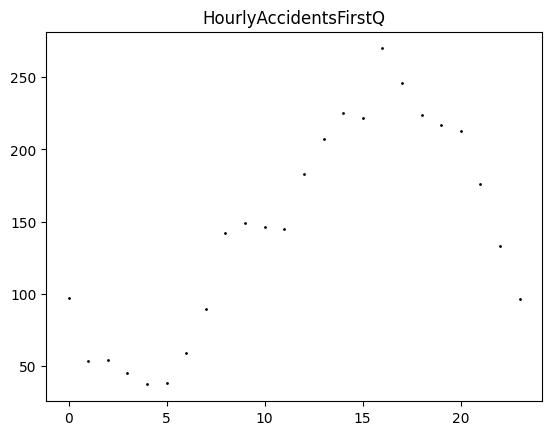

In [24]:
cosinor.plot_data(df_plot, names = ["HourlyAccidentsFirstQ"])

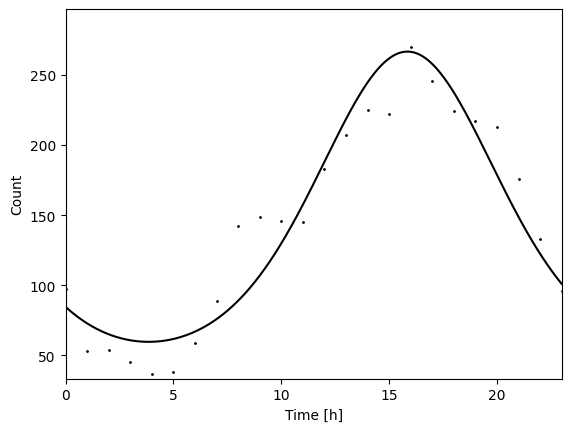

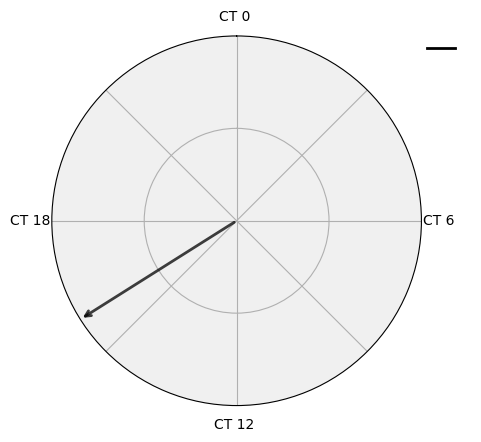

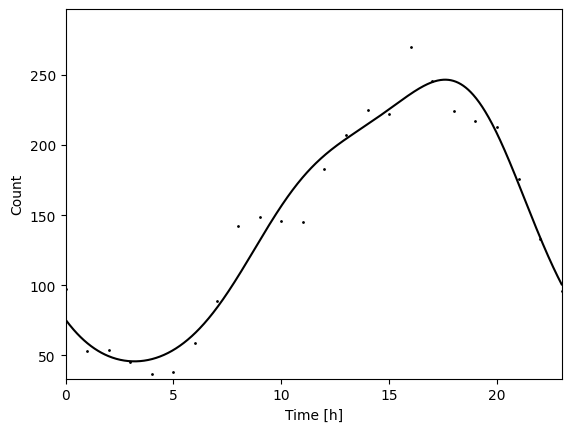

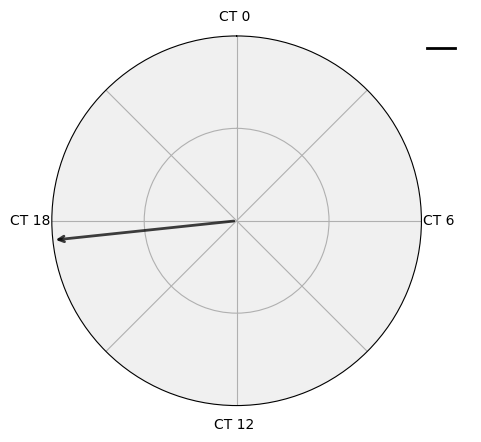

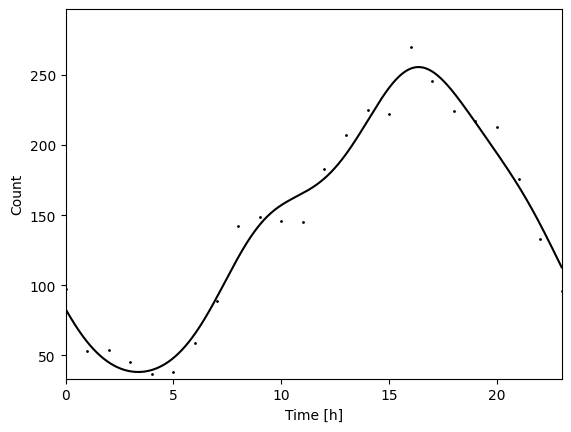

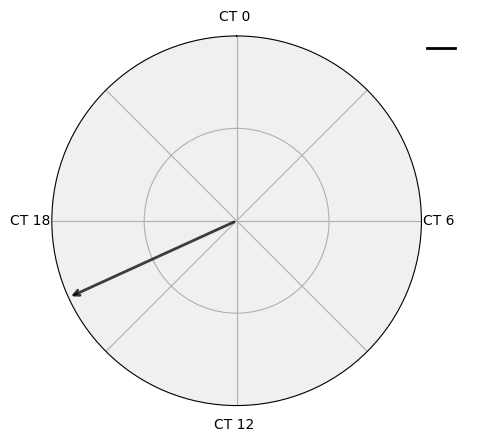

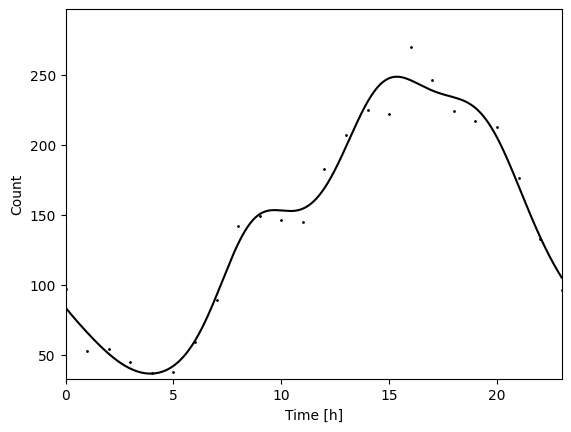

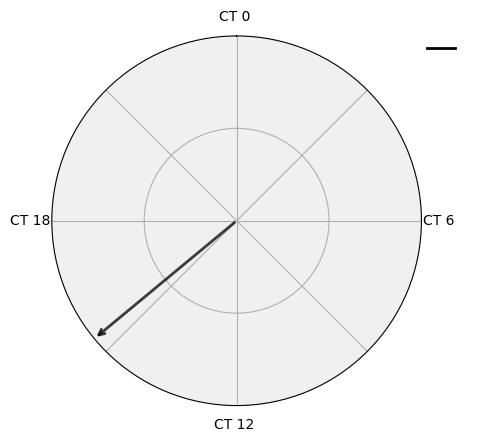

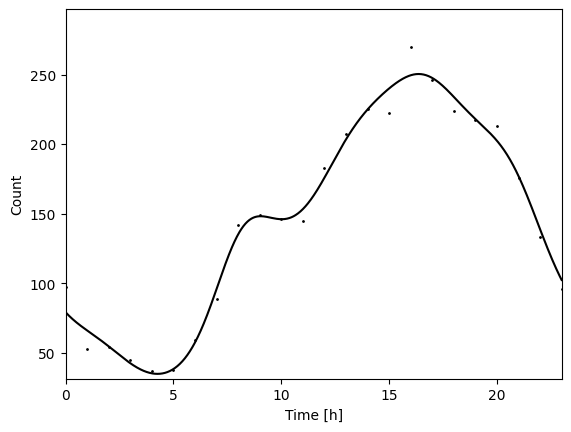

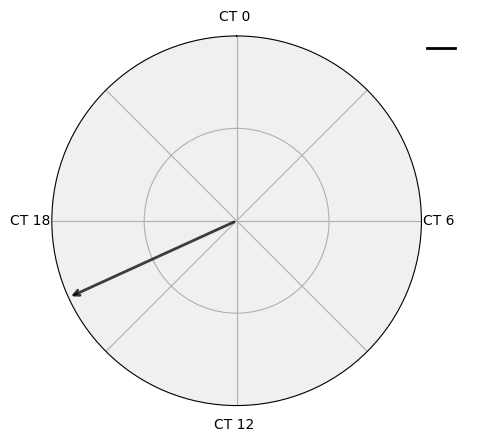

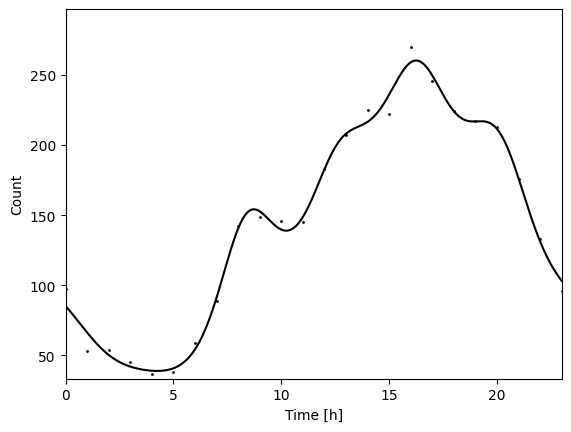

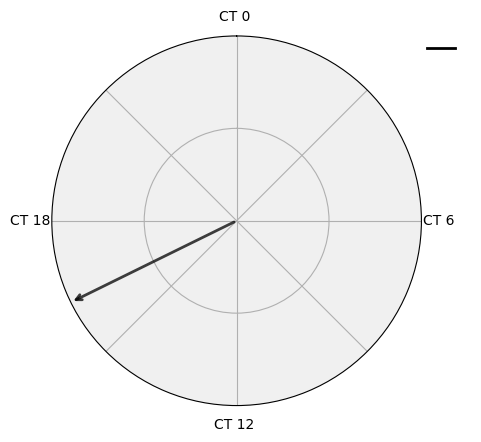

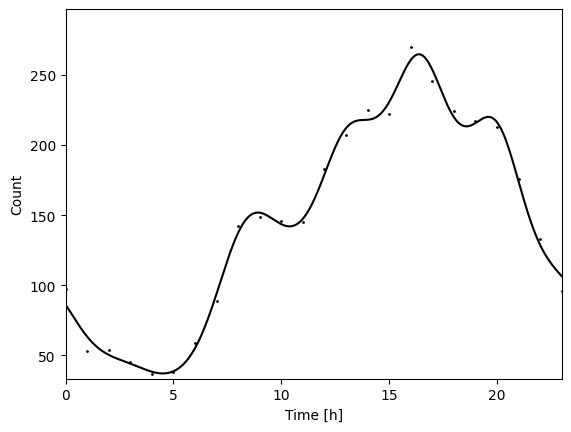

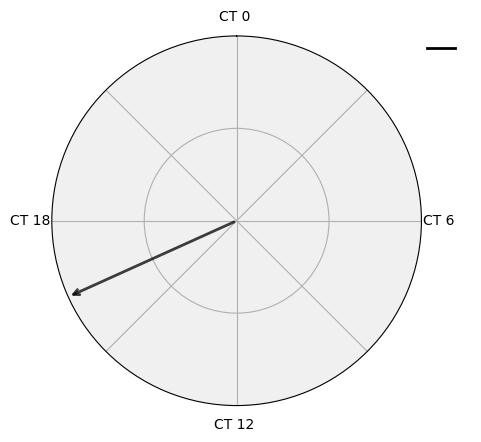

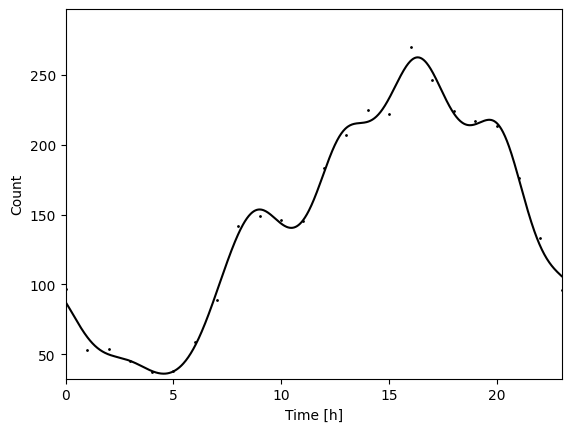

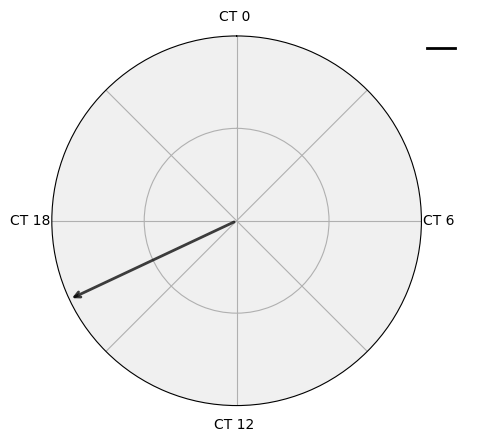

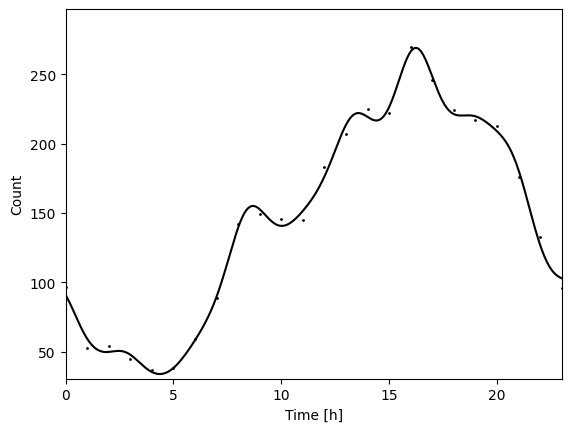

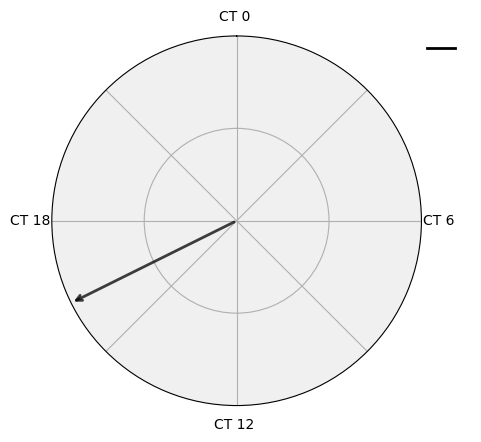

In [18]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)

all_models = []

numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9]
for n_component in numbers:
    results, statistics, rhythm_param, _, _, model = cosinor.fit_me(X, Y, n_components = n_component, period = 24, model_type = 'gen_poisson', plot_margins=False, return_model=True)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))
    # print(results.__dict__.keys())
    # print(results.summary())
    # print("AIC in BIC", results.aic, results.bic)
    # help(results)


    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsFirstQ', 
        'period': 24,
        'n_components': n_component,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'AIC': results.aic,
        'BIC': results.bic,
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })

    # Likelihood-ratio test
    if n_component == 1:
        DOF_simpler = 0
        n_params_simpler = 0
        n_component_simpler = 0
        results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = results, statistics, rhythm_param, model
        
    n_params = len(results.params)
    DOF = len(df_plot)-n_params
    llf = results.llf

    p_accept_llf = 0
    
    if DOF < DOF_simpler:
        p_accept_llf = cosinor.compare_models_LR_test(llf_simpler, llf, n_params_simpler, n_params)

    llf_simpler = llf
    DOF_simpler = DOF

    if p_accept_llf < 0.05:
        n_component_simpler, results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = n_component, results, statistics, rhythm_param, model

    all_models.append(['HourlyAccidentsFirstQ', n_component, results, statistics, rhythm_param, model, p_accept_llf])

df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

# Dataframe za najboljši model na podlagi likelihood-ratio testa
df_best_model = pd.DataFrame([{
        'test': 'HourlyAccidentsFirstQ',
        'period': 24,
        'n_components': n_component_simpler,
        'p': statistics_simpler['p'], 
        'RSS': statistics_simpler['RSS'],
        'log-likelihood': results_simpler.llf,        
        'prsquared': results_simpler.prsquared,  # Alternative to R²
        'AIC': results_simpler.aic,
        'BIC': results_simpler.bic,
        'amplitude': rhythm_param_simpler['amplitude'],
        'acrophase': rhythm_param_simpler['acrophase'],
        'mesor': rhythm_param_simpler['mesor'],
        'peaks': rhythm_param_simpler['peaks'],
        'heights': rhythm_param_simpler['heights'],
        'troughs': rhythm_param_simpler['troughs'],
        'heights2': rhythm_param_simpler['heights2']
    }])

In [19]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2,AIC,BIC
0,HourlyAccidentsFirstQ,24.0,1.0,3.041127e-13,3.041127e-13,11801.217933,-108.977586,0.209155,103.536694,2.133355,163.159145,[15.851185118511852],[266.6958264240213],[3.8499849984998504],[59.62245124993076],225.955173,230.667388
1,HourlyAccidentsFirstQ,24.0,2.0,5.646947e-16,6.352815e-16,5810.167509,-99.005003,0.281526,100.484011,1.675893,146.176715,[17.5985598559856],[246.66072615506246],[3.1923192319231926],[45.69270417960994],210.010006,217.078329
2,HourlyAccidentsFirstQ,24.0,3.0,3.742491e-17,4.811774e-17,3477.417571,-93.019781,0.324960,108.776337,1.998881,146.885590,[16.364836483648364],[255.6619232057684],[3.3651365136513656],[38.10925301876286],202.039561,211.463992
3,HourlyAccidentsFirstQ,24.0,4.0,3.801178e-18,5.701767e-18,2643.562685,-87.675617,0.363743,106.081106,2.262801,142.623607,"[9.677767776777678, 15.356735673567359]","[153.37585611388056, 248.70471354203326]",[3.9363936393639367],[36.542519152390234],195.351235,207.131773
4,HourlyAccidentsFirstQ,24.0,5.0,2.726334e-18,4.907402e-18,1765.181616,-84.557580,0.386370,107.733045,1.998881,142.642065,"[9.03930393039304, 16.364836483648364]","[148.18671182692586, 250.37510668717397]",[4.258025802580258],[34.90902072047698],193.115159,207.251805
5,HourlyAccidentsFirstQ,24.0,6.0,1.619390e-19,6.773042e-19,905.095985,-78.848959,0.427797,110.748472,2.027787,149.606046,"[8.727272727272728, 16.254425442544257, 19.264...","[154.18173579814936, 260.3544300570645, 217.02...","[4.243624362436244, 10.22982298229823]","[38.85757869780571, 138.91873585938288]",185.697919,202.190672
6,HourlyAccidentsFirstQ,24.0,7.0,2.257681e-19,6.773042e-19,794.961648,-76.663481,0.443657,113.866526,1.995111,150.923033,"[8.914491449144915, 16.37923792379238, 19.6051...","[151.86569472589682, 264.7895594719018, 220.11...","[4.507650765076508, 10.378637863786379]","[37.05651743808135, 142.00836728812746]",185.326961,204.175823
7,HourlyAccidentsFirstQ,24.0,8.0,1.203300e-18,2.707425e-18,810.975100,-76.087188,0.447839,113.205341,2.010192,149.278632,"[8.991299129912992, 16.32163216321632, 19.6435...","[153.6049749759143, 262.48393169307934, 217.79...","[4.546054605460546, 10.46024602460246]","[36.073300419712915, 140.4312610462061]",188.174377,209.379345
8,HourlyAccidentsFirstQ,24.0,9.0,6.681349e-20,6.013214e-19,495.794584,-70.447531,0.488766,117.553196,2.031557,151.504880,"[8.684068406840685, 13.575757575757576, 16.240...","[155.10216147962623, 222.0777396448177, 269.05...","[1.8817881788178819, 4.363636363636364, 10.023...","[49.78713148420219, 33.951691309220955, 140.73...",180.895062,204.456138


### Katero je najboljše število komponent

In [20]:
# df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model
# print(df_best_model)

,test,period,n_components,p,RSS,log-likelihood,prsquared,AIC,BIC,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsFirstQ,24,2,5.646947e-16,5810.167509,-99.005003,0.281526,210.010006,217.078329,100.484011,1.675893,146.176715,[17.5985598559856],[246.66072615506246],[3.1923192319231926],[45.69270417960994]


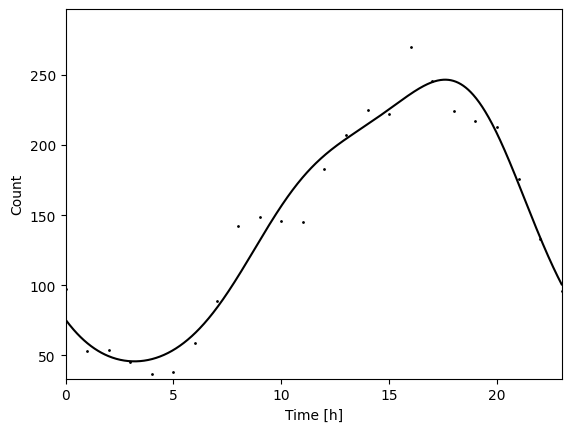

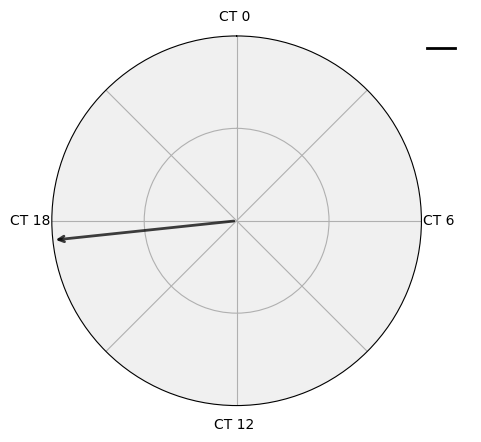

(<statsmodels.discrete.discrete_model.GeneralizedPoissonResultsWrapper at 0x1e717689970>,
 {'p': 5.646946655805048e-16, 'RSS': 5810.167509406577, 'count': 3466},
 {'period': 24,
  'amplitude': 100.48401098772626,
  'acrophase': 1.6758931107358688,
  'mesor': 146.1767151673362,
  'peaks': array([17.59855986]),
  'heights': array([246.66072616]),
  'troughs': array([3.19231923]),
  'heights2': array([45.69270418]),
  'max_loc': 3666,
  'period2': 24},
 array([0.00000000e+00, 4.80048005e-03, 9.60096010e-03, ...,
        4.79903990e+01, 4.79951995e+01, 4.80000000e+01]),
 array([75.37324439, 75.27357303, 75.17410237, ..., 75.57318965,
        75.47311656, 75.37324439]))

In [ ]:
# cosinor.fit_me(X, Y, n_components = 2, period = 24, model_type = 'gen_poisson', save_to = "../PisanjeDiplome/angleskeSlike/kosinor-prvi-krajec", plot=True, plot_margins=False)
cosinor.fit_me(X, Y, n_components = 2, period = 24, model_type = 'gen_poisson', plot=True, plot_margins=False)

## RhythmCount

In [10]:
# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo RhythmCount
df_plot_RC = pd.DataFrame({
    "test": "HourlyAccidentsFirstQ",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour.values  # Število nesreč za tisto uro
})

In [11]:
count_models = ['gen_poisson', 'nb']
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

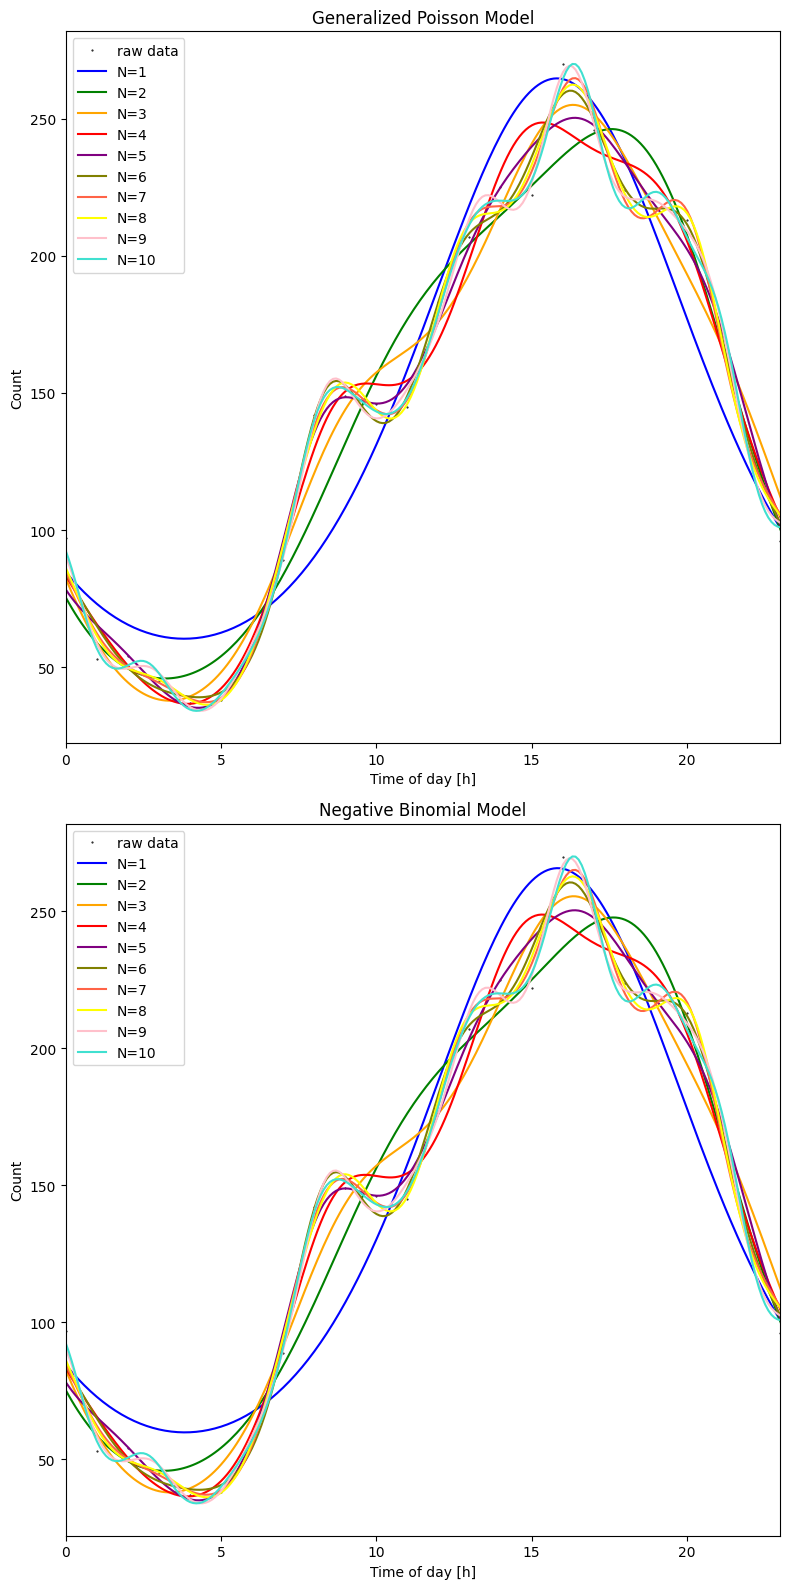

In [12]:
df_results_RC = dproc.fit_to_models(df_plot_RC, count_models, n_components, 24)

In [13]:
display(df_results_RC)

,count_model,n_components,amplitude,mesor,peaks,heights,llr_pvalue,RSS,AIC,BIC,log_likelihood,logs,mean(est),Y(est),X_test,Y_test
0,gen_poisson,1,102.13,162.51,[15.82],[264.64],3.134319e-13,11636.006068,226.015541,230.727756,-109.007770,"[-4.1939044873575995, -4.2780754612179805, -3....",144.260733,"[84.72381467898352, 73.13278310878606, 65.5263...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[84.72381467898352, 83.3675492473207, 82.05644..."
1,gen_poisson,2,100.14,146.03,[17.62],[246.16],3.519664e-15,5778.892353,213.766373,220.834696,-100.883186,"[-5.755612897621134, -3.232512699749705, -3.15...",144.261126,"[75.50151760691924, 58.91362853250337, 49.5368...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[75.50151760691924, 73.472657514565, 71.529368..."
2,gen_poisson,3,108.59,146.39,[16.32],[254.99],5.945846e-17,3459.933616,203.007956,212.432387,-93.503978,"[-4.538507538586373, -3.2079269661238072, -3.9...",144.170986,"[82.48125117365949, 59.03805506285004, 44.4833...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[82.48125117365949, 79.76955857379113, 77.1308..."
3,gen_poisson,4,105.95,142.59,[15.32],[248.55],4.112578e-18,2641.219059,195.518531,207.299069,-87.759265,"[-4.406927159715764, -4.433337088060185, -2.93...",144.416667,"[83.40592701069279, 65.6979869901275, 50.61143...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[83.40592701069279, 81.50984395434868, 79.6471..."
4,gen_poisson,5,107.53,142.73,[16.42],[250.26],5.318066e-18,1765.306084,194.558501,208.695147,-85.279251,"[-5.6818203506282, -4.365761222406718, -2.8077...",144.416667,"[78.3742564270201, 65.41072569216229, 54.48011...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[78.3742564270201, 76.7362483953174, 75.200180..."
5,gen_poisson,6,110.56,149.60,"[16.22, 19.22]","[260.16, 217.22]",3.621823e-18,908.039602,192.495899,208.988653,-82.247950,"[-4.27889106524583, -4.297627754212371, -2.999...",144.416667,"[84.0460167246928, 65.11570699304329, 49.90713...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[84.0460167246928, 82.1876149996913, 80.310036..."
6,gen_poisson,7,113.74,150.99,"[16.42, 19.62]","[264.73, 220.33]",1.565592e-17,793.481107,194.750003,213.598865,-81.375002,"[-4.125555687687566, -3.7300268086119743, -2.9...",144.416667,"[84.86554125046402, 62.38370089092668, 50.1614...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[84.86554125046402, 82.44009330628711, 80.0031..."
7,gen_poisson,8,113.05,149.35,"[16.32, 19.62]","[262.39, 218.03]",1.079158e-16,813.417874,198.349267,219.554236,-81.174634,"[-3.880032806981646, -3.5772762166956866, -3.0...",144.416667,"[86.33241883032855, 61.53056467969578, 49.6510...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[86.33241883032855, 83.7774265456158, 81.15667..."
8,gen_poisson,9,117.55,151.69,"[13.61, 16.22, 18.62]","[222.07, 269.24, 220.67]",2.058005e-16,496.240095,199.265107,222.826183,-79.632553,"[-3.38301363443928, -3.172748982529164, -3.038...",144.416667,"[90.39984770792391, 58.79938705916221, 49.5441...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[90.39984770792391, 87.51481664994813, 84.3584..."
9,gen_poisson,10,117.91,151.99,"[13.91, 16.32, 19.02]","[220.08, 269.9, 223.29]",9.153951e-16,466.555621,202.338561,228.255745,-79.169280,"[-3.222753034648804, -2.971249629386911, -2.93...",144.416667,"[92.54612171746305, 56.88421092722368, 50.6686...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[92.54612171746305, 89.33595929207675, 85.7275..."


## Kateri model je najboljši?

#### Najprej pogledamo, kateri model je najboljši, nato kolikšno število komponent je najboljše.

In [14]:
best_count_model = dproc.get_best_count_model(df_results_RC, 'Vuong')
print("Best model: {}".format(best_count_model.count_model))
best_model = dproc.get_best_n_components(df_results_RC, 'Vuong', count_model=best_count_model['count_model'])
print("Number of components: {}".format(best_model.n_components))

Best model: gen_poisson
Number of components: 6


#### Najprej pogledamo, kolikšno število komponent je najboljše, nato, kateri model je najboljši. 

In [15]:
best_n_components = dproc.get_best_n_components(df_results_RC, 'Vuong')
print("Number of components: {}".format(best_n_components.n_components))
best_model = dproc.get_best_count_model(df_results_RC, 'Vuong', n_components=best_n_components['n_components'])
print("Best model: {}".format(best_model.count_model))

Number of components: 6
Best model: gen_poisson


### Prikaz najboljšega modela skupaj z intervali zaupanja

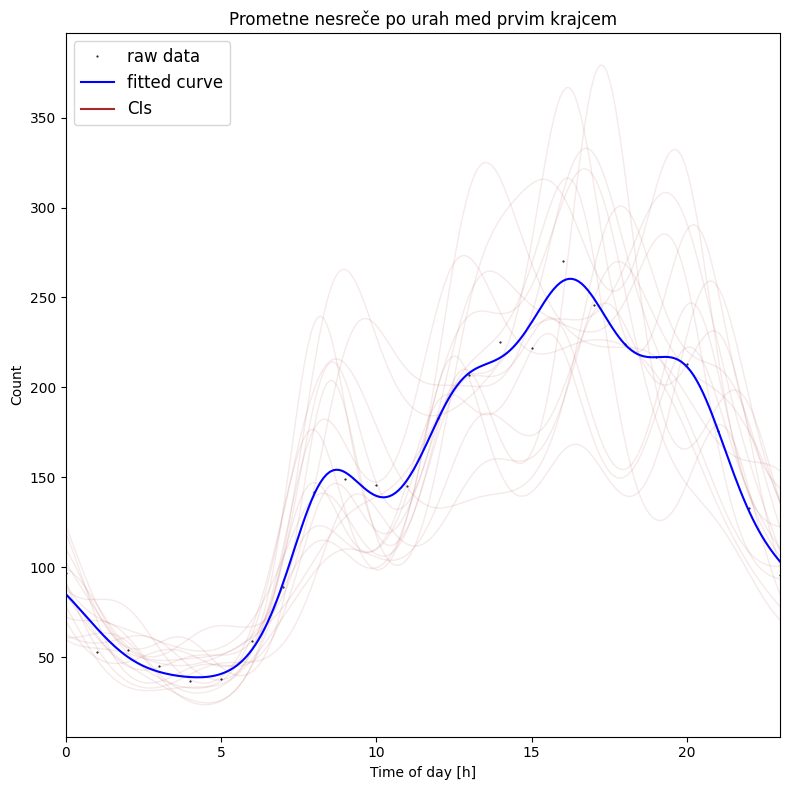

Intervali zaupanja:


,0,1
0,4.694721,4.936943
1,-0.853584,-0.549972
2,-0.613819,-0.280956
3,-0.417296,-0.081135
4,-0.080319,0.114174
5,-0.157633,0.148969
6,0.040944,0.184337
7,-0.065466,0.162272
8,-0.170251,0.053993
9,-0.134340,0.029645


In [16]:
# print(type(best_model))
# print(type(best_n_components))

# print(best_n_components)

count_model = best_model.count_model
n_components = int(best_n_components.n_components)

CIs = plot.plot_model(df_plot_RC, count_model, n_components, title='Prometne nesreče po urah med prvim krajcem', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs)

### Parametri izbranega modela

In [17]:
CIs_params = dproc.calculate_confidence_intervals_parameters(df_plot_RC, n_components, count_model, best_model['peaks'])
best_model = pd.concat([best_model, pd.Series(CIs_params)], axis=0)
best_model=best_model[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model.to_frame())

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,6
amplitude,110.56
mesor,149.6
peaks,"[16.22, 19.22]"
heights,"[260.16, 217.22]"
amplitude_CIs,"[-220.12, 548.76]"
mesor_CIs,"[-184.0, 584.25]"
peaks_CIs,"[[14.84, 17.23], [19.15, 19.99]]"
heights_CIs,"[[222.06, 309.48], [200.54, 244.39]]"
